In [5]:
time_idx = 0 ## the time index value within the hour - usually there are 11 index values

**Load python libraries**

In [6]:
%matplotlib inline
import boto3
import botocore
import requests
from dask.distributed import Client, progress
import netCDF4
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display

from botocore import UNSIGNED
from botocore.config import Config

# path to modules
import sys
sys.path.append('../modules')

from GOESR_functions import goes_lat_lon_reproj#, get_s3_keys
from plotter import loadCPT

In [7]:
def get_s3_keys(bucket, s3_client, prefix = ''):
    """
    Generate the keys in an S3 bucket.

    :param bucket: Name of the S3 bucket.
    :param prefix: Only fetch keys that start with this prefix (optional).
    """
    
    kwargs = {'Bucket': bucket}

    if isinstance(prefix, str):
        kwargs['Prefix'] = prefix

    while True:
        resp = s3_client.list_objects_v2(**kwargs)
        for obj in resp['Contents']:
            key = obj['Key']
            if key.startswith(prefix):
                yield key

        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break

**Connect to Dask Distributed Cluster**

Set the `memory_limit` parameter in `Client()` if dask doesn't auto detect your memory limit accurately later on in the notebook. You will know this is occurring if processes start to get killed due to memory limit errors.

In [8]:
from dask.distributed import Client
daskclient = Client(processes=True, n_workers=3, memory_limit='8GB')
daskclient

Client Scheduler: tcp://127.0.0.1:35773 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 48 Memory: 22.35 GiB


**Set up access to S3 bucket using `boto3` and a low-level client**

Rather than setting up access key and ID, we will use a low-level client to request data anonymously.

In [9]:
# No AWS keys required
client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED))

Let's check out what is in the NOAA GOES AWS bucket. For more information on each of the products, see this [documentation](https://docs.opendata.aws/noaa-goes16/cics-readme.html). 

In [10]:
bucket_name = 'noaa-goes16'

paginator = client.get_paginator('list_objects')
result = paginator.paginate(Bucket=bucket_name, Delimiter='/')
for prefix in result.search('CommonPrefixes'):
    print(prefix.get('Prefix'))

ABI-L1b-RadC/
ABI-L1b-RadF/
ABI-L1b-RadM/
ABI-L2-ACHAC/
ABI-L2-ACHAF/
ABI-L2-ACHAM/
ABI-L2-ACHTF/
ABI-L2-ACHTM/
ABI-L2-ACMC/
ABI-L2-ACMF/
ABI-L2-ACMM/
ABI-L2-ACTPC/
ABI-L2-ACTPF/
ABI-L2-ACTPM/
ABI-L2-ADPC/
ABI-L2-ADPF/
ABI-L2-ADPM/
ABI-L2-AICEF/
ABI-L2-AITAF/
ABI-L2-AODC/
ABI-L2-AODF/
ABI-L2-CMIPC/
ABI-L2-CMIPF/
ABI-L2-CMIPM/
ABI-L2-CODC/
ABI-L2-CODF/
ABI-L2-CPSC/
ABI-L2-CPSF/
ABI-L2-CPSM/
ABI-L2-CTPC/
ABI-L2-CTPF/
ABI-L2-DMWC/
ABI-L2-DMWF/
ABI-L2-DMWM/
ABI-L2-DMWVC/
ABI-L2-DMWVF/
ABI-L2-DMWVM/
ABI-L2-DSIC/
ABI-L2-DSIF/
ABI-L2-DSIM/
ABI-L2-DSRC/
ABI-L2-DSRF/
ABI-L2-DSRM/
ABI-L2-FDCC/
ABI-L2-FDCF/
ABI-L2-FDCM/
ABI-L2-LSTC/
ABI-L2-LSTF/
ABI-L2-LSTM/
ABI-L2-LVMPC/
ABI-L2-LVMPF/
ABI-L2-LVMPM/
ABI-L2-LVTPC/
ABI-L2-LVTPF/
ABI-L2-LVTPM/
ABI-L2-MCMIPC/
ABI-L2-MCMIPF/
ABI-L2-MCMIPM/
ABI-L2-RRQPEF/
ABI-L2-RSRC/
ABI-L2-RSRF/
ABI-L2-SSTF/
ABI-L2-TPWC/
ABI-L2-TPWF/
ABI-L2-TPWM/
ABI-L2-VAAF/
EXIS-L1b-SFEU/
EXIS-L1b-SFXR/
GLM-L2-LCFA/
MAG-L1b-GEOF/
SEIS-L1b-EHIS/
SEIS-L1b-MPSH/
SEIS-L1b-MPSL/
SEIS-L1

In [21]:
product_name = 'ABI-L2-CMIPC'
year = 2017
day_of_year = 149
hour = 15
band = 2

prefix = product_name + '/' + str(year) + '/' + str(day_of_year).zfill(3)  \
+ '/' + str(hour).zfill(2) + '/OR_'+ product_name + '-M3C' + str(band).zfill(2)
prefix

'ABI-L2-CMIPC/2017/149/15/OR_ABI-L2-CMIPC-M3C02'

In [22]:
# Initialize s3 client. 
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

In [23]:
keys = get_s3_keys(bucket_name, s3_client, prefix = prefix)

s3_data_key = [key for key in keys][time_idx] ## specific time between 0 and 11
# s3_data_key = [key for key in keys][0] # selecting the first measurement taken within the hour

**Download netcdf for specified key**

In [24]:
resp = requests.get('https://' + bucket_name + '.s3.amazonaws.com/' + s3_data_key)

In [25]:
file_name = s3_data_key.split('/')[-1].split('.')[0]
nc4_ds = netCDF4.Dataset(file_name, memory = resp.content)
store = xr.backends.NetCDF4DataStore(nc4_ds)
DS = xr.open_dataset(store)
# DS

**Convert radiance scan x, y data into derived latitude and longitude values using [this tutorial](https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm).**

In [26]:
lats, lons = goes_lat_lon_reproj(DS)
# print test coordinates
print('{} N, {} W'.format(lats[318,1849],abs(lons[318,1849])))

47.79497146606445 N, 115.7514877319336 W


**Plot using cartopy**

In [27]:
# Converts a CPT file to be used in Python
cpt = loadCPT('/home/sbarc/students/nash/data/Colortables/IR4AVHRR6.cpt')

In [28]:
# datacrs = ccrs.PlateCarree()  ## the projection the data is in
# mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in
# ext = (-122., -118., 33., 36.)


# ax = plt.axes(projection=mapcrs)
# ax.set_extent(ext, crs=mapcrs)

# cm = ax.pcolormesh(lons, lats, DS.CMI, transform=datacrs, cmap = 'gray')

/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1703: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/sbarc/students/coello/miniconda3/envs/goes/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


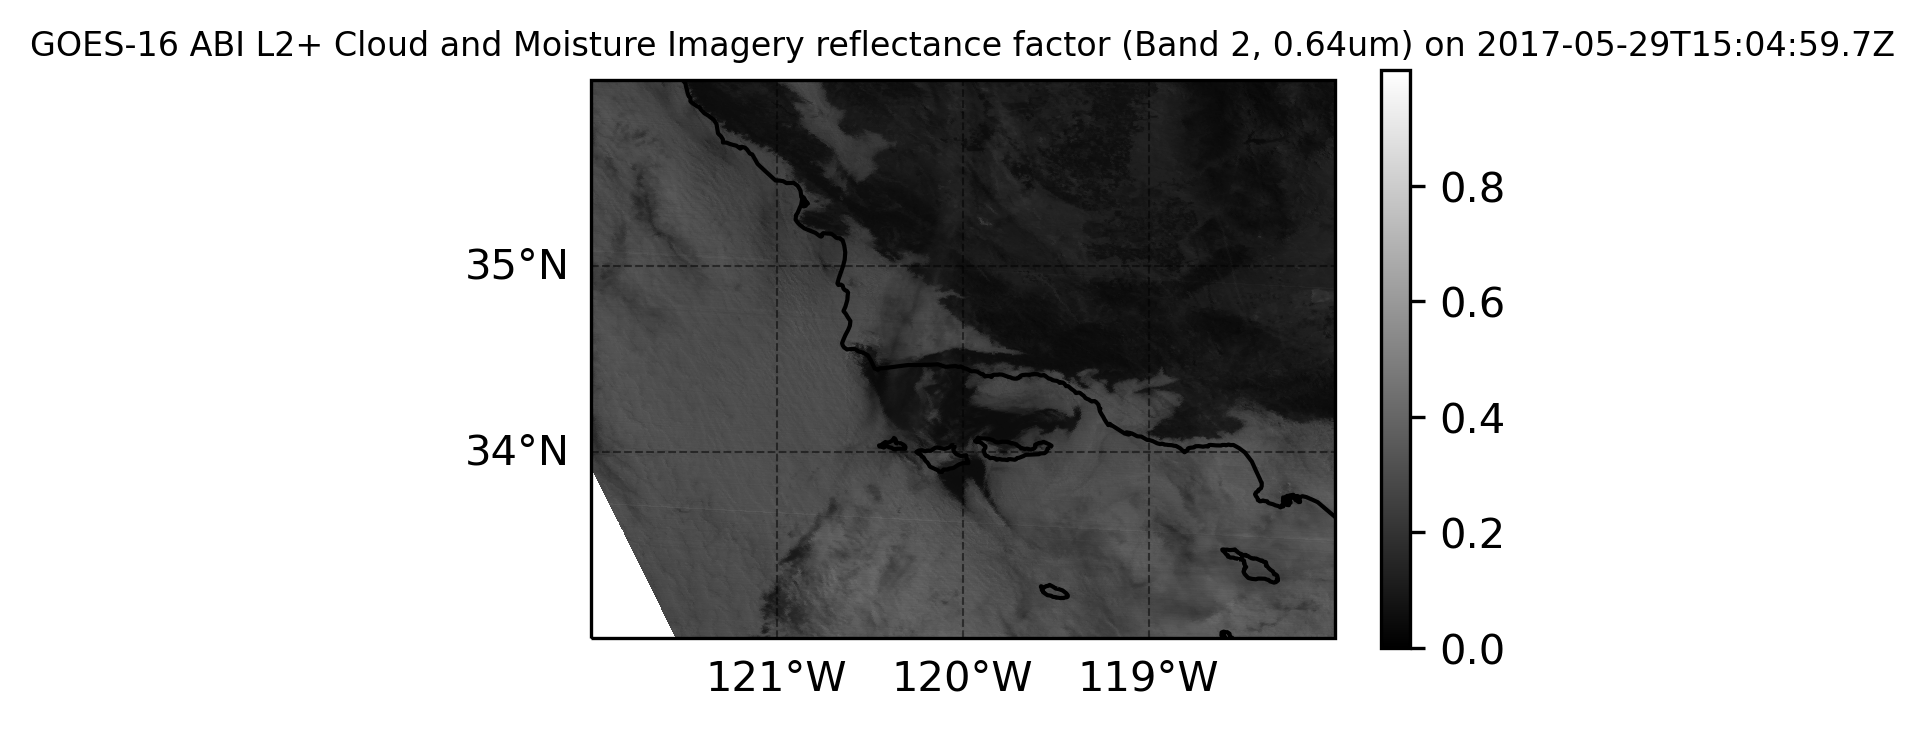

In [29]:
# fig = plt.figure(figsize=(4,3))
# fig.dpi = 300
# fname = './results/' + file_name
# fmt = 'png'

# results = DS.CMI #- 273.15 ## Convert to Celsius
# ext = (-122., -118., 33., 36.)

# datacrs = ccrs.PlateCarree()  ## the projection the data is in
# mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# ax = plt.axes(projection=mapcrs)
# ax.set_extent(ext, crs=mapcrs)

# cm = ax.pcolormesh(lons, lats, results, transform=datacrs, cmap = 'gray') #, cmap=cpt, vmin=-103, vmax=84)
# gl = ax.gridlines(crs=datacrs, draw_labels=True,
#                   linewidth=.5, color='black', alpha=0.5, linestyle='--')
# gl.xlocator = mticker.FixedLocator(np.arange(-122., -117.75, 1.))
# gl.ylocator = mticker.FixedLocator(np.arange(33., 37., 1.))
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabels_top = False
# gl.ylabels_right = False
# coast = ax.coastlines(resolution='10m')

# band_info = '(Band ' + str(DS.band_id.values[0]) + ', ' \
# + str(DS.band_wavelength.values[0]) + DS.band_wavelength.units + ')'
# plt.title('GOES-16 {0} {1} on {2}'.format(DS.CMI.long_name, band_info, DS.time_coverage_end), 
#           fontsize=8)


# # Add a color bar
# cbar = plt.colorbar(cm, shrink=0.85, orientation='vertical')

# # Unit = "Brightness Temperature ($\mathrm{\degree C}$)"
# # cbar.set_label(Unit, fontsize=9)

# # # fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)
# # fig.clf()

# # plotFile = fname + '.png'
# # print(plotFile)
# # display(Image(plotFile))